# Research Question: How can Data Analyst maximize salary — what to learn and where to work in Vietnam?
1. Which locations offer the best balance of salary and job demand?
2. Which technical skills provide the best balance between salary potential and market demand?
3. Can newcomers still earn competitive salaries without a degree or with remote roles?

Load the dataset

In [2]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
# Loading Dataset
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()
# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [3]:
df_da_vn = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Vietnam')].copy()

df_loc = df_da_vn[(df_da_vn['job_location'] != 'Vietnam')].copy()

df_loc = df_loc[~df_loc['job_location'].isin(["Vietnam", "Anywhere"])]
df_loc = df_loc[~df_loc['job_location'].str.contains("other", na=False, case=False)]

def clean_location(x):
    if pd.isna(x):
        return "Other"
    if "Ho Chi Minh" in x:
        return "Ho Chi Minh City"
    elif "Hanoi" in x:
        return "Hanoi"
    elif "Da Nang" in x:
        return "Da Nang"
    elif "Binh Duong" in x:
        return "Binh Duong"
    elif "Dong Nai" in x:
        return "Dong Nai"
    elif "Bình Định" in x:
        return "Binh Dinh"
    elif "Quảng Nam" in x:
        return "Quang Nam"
    elif "Bắc Giang" in x or "Bac Giang" in x:
        return "Bac Giang"
    elif "Thua Thien Hue" in x:
        return "Thua Thien Hue"
    else:
        return "Other"

df_loc['city'] = df_loc['job_location'].apply(clean_location)

## Which locations offer the best balance of salary and job demand?
Methodology
1. Group job postings by job_location (e.g., Hanoi, HCMC).
2. Calculate median salary per location.
3. Compare demand (posting counts) vs pay (median salary).
4. Visualize with scatter plot (x = demand, y = salary).

Group job postings by job_location (e.g., Hanoi, HCMC).

In [4]:
df_city_posted = (
    df_loc['city']
    .value_counts()
    .reset_index(name='no_job_posted')
    .rename(columns={'index': 'city'})
    .sort_values('no_job_posted', ascending=False)
)

df_city_posted

,city,no_job_posted
0,Ho Chi Minh City,121
1,Hanoi,70
2,Da Nang,18
3,Binh Duong,4
4,Dong Nai,2
5,Quang Nam,1
6,Binh Dinh,1
7,Bac Giang,1


Calculate median salary per location.

In [5]:
df_city_salary = (
    df_loc
    .groupby('city', as_index=False)['salary_year_avg']
    .median()
    .rename(columns={'salary_year_avg': 'median_salary'})
    .sort_values('median_salary', ascending=False)
)

df_city_salary

,city,median_salary
5,Hanoi,111175.0
6,Ho Chi Minh City,100500.0
0,Bac Giang,NaN
1,Binh Dinh,NaN
2,Binh Duong,NaN
3,Da Nang,NaN
4,Dong Nai,NaN
7,Quang Nam,NaN


Compare demand (posting counts) vs pay (median salary).

In [6]:
df_plot = df_city_posted.merge(df_city_salary, on='city').set_index('city')
df_plot.dropna(inplace=True)
df_plot

,no_job_posted,median_salary
city,,
Ho Chi Minh City,121,100500.0
Hanoi,70,111175.0


Visualize with scatter plot (x = demand, y = salary).

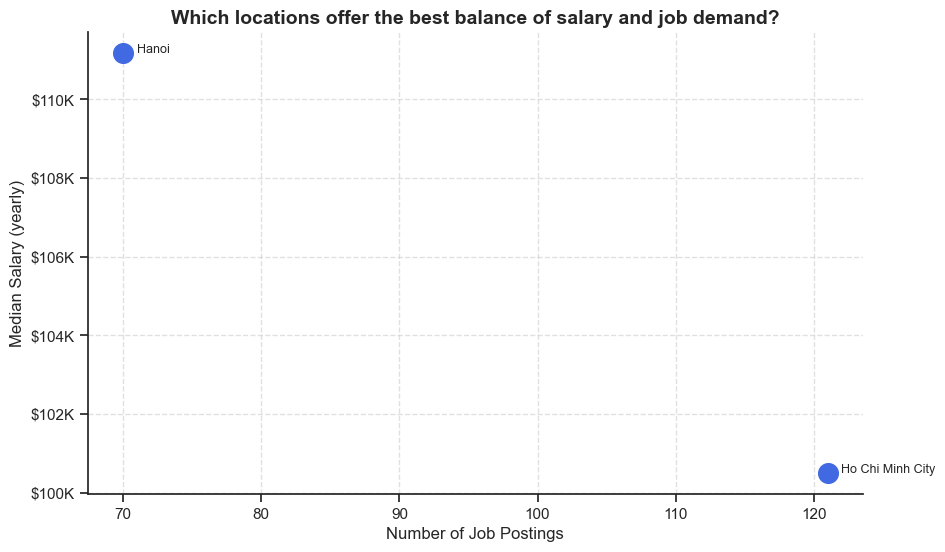

In [7]:
sns.set_theme(style="ticks")
plt.figure(figsize=(10,6))

plt.scatter(
    df_plot['no_job_posted'],
    df_plot['median_salary'],
    s=200,              
    color='royalblue'
)

for city, row in df_plot.iterrows():
    plt.text(
        row['no_job_posted']+1,
        row['median_salary'],
        city,
        fontsize=9
    )

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'${int(x/1000)}K'))

sns.despine()
plt.title("Which locations offer the best balance of salary and job demand?", fontsize=14, fontweight='bold')
plt.xlabel("Number of Job Postings")
plt.ylabel("Median Salary (yearly)")

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Which technical skills provide the best balance between salary potential and market demand?
Methodology
1. Group by skill to calculate median salary and demand (count of postings)
2. Identify top 10 highest–paying skills and top 10 most in-demand skills
3. Visualize results with bar charts to compare salary potential vs market demand

Group by skill to calculate median salary and demand (count of postings)

In [8]:
df_da_vn_explode = df_da_vn.explode('job_skills').copy()

df_da_vn_explode[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
3056,NaN,sql
3056,NaN,python
3056,NaN,excel
10122,NaN,sql
10122,NaN,vba


Identify top 10 highest–paying skills and top 10 most in-demand skills

In [9]:
df_da_top_pay = df_da_vn_explode.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values('median', ascending=False)

df_da_top_pay = df_da_top_pay.head(10)

df_da_top_pay

,count,median
job_skills,,
looker,1,100500.0
word,1,100500.0
sql,8,64282.0
java,2,63282.0
sap,2,63282.0
sql server,2,63282.0
python,4,63282.0
oracle,2,63282.0
tableau,3,53014.0


In [10]:
df_da_skills = df_da_vn_explode.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values('count', ascending=False)

df_da_skills = df_da_skills.head(10).sort_values(by='median', ascending=False)

df_da_skills

,count,median
job_skills,,
sql,8,64282.0
python,4,63282.0
sql server,2,63282.0
sap,2,63282.0
java,2,63282.0
oracle,2,63282.0
power bi,5,53014.0
tableau,3,53014.0
macos,2,53014.0


Visualize results with bar charts to compare salary potential vs market demand

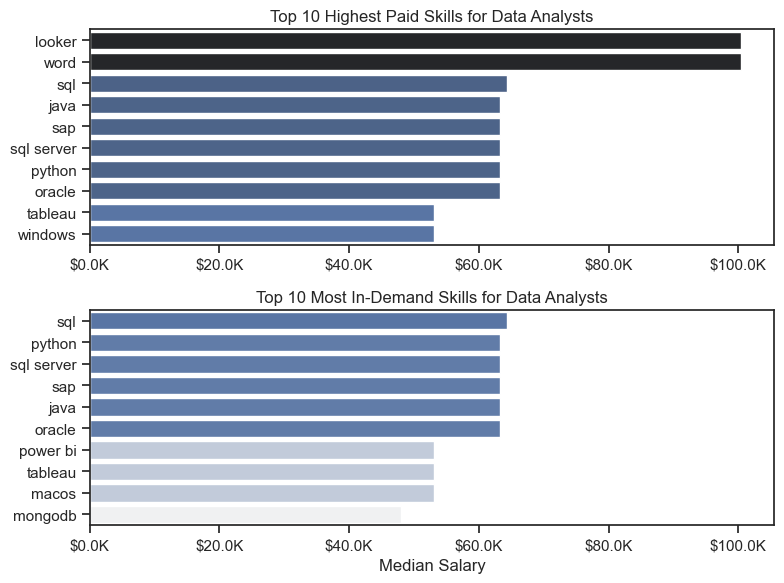

In [11]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(2,1, figsize=(8,6))

sns.barplot(data=df_da_top_pay, x='median', y='job_skills',
            ax=ax[0], hue='median', palette='dark:b_r', legend=False)
ax[0].set_title('Top 10 Highest Paid Skills for Data Analysts')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'${int(x)/1000}K'))

sns.barplot(data=df_da_skills, x='median', y='job_skills',
            ax=ax[1], hue='median', palette='light:b', legend=False)
ax[1].set_title('Top 10 Most In-Demand Skills for Data Analysts')
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'${int(x)/1000}K'))

fig.tight_layout()
plt.show()

## Can newcomers still earn competitive salaries without a degree or with remote roles?
Methodology
1. Split postings by job_no_degree_mention and job_work_from_home.
2. Compare median salaries for postings with vs without degree requirement.
3. Overlay skill requirements to see which “accessible” jobs still offer strong pay.
4. Visualize with boxplots (salary by accessibility type).

Split postings by job_no_degree_mention and job_work_from_home.

In [12]:
df_job_posted = df_da_vn.groupby(['job_no_degree_mention', 'job_work_from_home']).size().reset_index(name='no_job_posted')
df_job_posted

,job_no_degree_mention,job_work_from_home,no_job_posted
0,False,False,164
1,False,True,9
2,True,False,151
3,True,True,10


Compare median salaries for postings with vs without degree requirement.

In [13]:
df_salary = df_da_vn.groupby(['job_no_degree_mention', 'job_work_from_home'])['salary_year_avg'].median().reset_index(name='median_salary')
df_salary

,job_no_degree_mention,job_work_from_home,median_salary
0,False,False,72000.0
1,False,True,NaN
2,True,False,106837.5
3,True,True,NaN


Overlay skill requirements to see which “accessible” jobs still offer strong pay.

In [14]:
df_plot = df_job_posted.merge(df_salary, on=['job_no_degree_mention', 'job_work_from_home'])
df_plot

,job_no_degree_mention,job_work_from_home,no_job_posted,median_salary
0,False,False,164,72000.0
1,False,True,9,NaN
2,True,False,151,106837.5
3,True,True,10,NaN


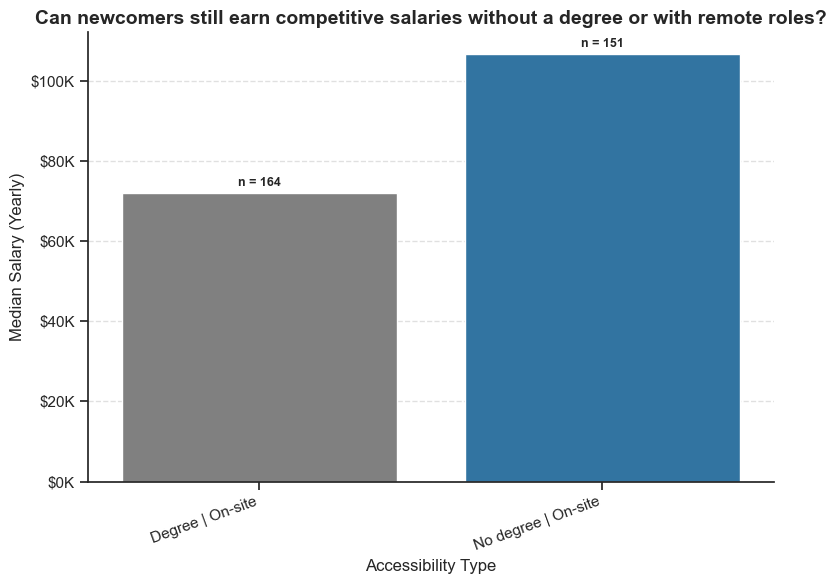

In [24]:
plt.figure(figsize=(8,6))
sns.set_theme(style="ticks")

df_plot_viz = df_plot.dropna().copy()
df_plot_viz['accessibility_type'] = df_plot_viz.apply(
    lambda x: f"{'No degree' if x['job_no_degree_mention'] else 'Degree'} | "
              f"{'Remote' if x['job_work_from_home'] else 'On-site'}",
    axis=1
)

df_grouped = df_plot_viz.groupby('accessibility_type').agg(
    median_salary=('median_salary', 'median'),
    n=('no_job_posted', 'sum')
).reset_index()

palette = {}
for cat in df_grouped['accessibility_type']:
    if "No degree" in cat:
        palette[cat] = "#1f77b4"   
    else:
        palette[cat] = "gray"      

ax = sns.barplot(
    data=df_grouped,
    x='accessibility_type',
    y='median_salary',
    hue='accessibility_type',     
    palette=palette,              
    legend=False                 
)

for p, n in zip(ax.patches, df_grouped['n']):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(
        x,
        y + 1000,
        f"n = {n}",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f'${int(x/1000)}K'))
sns.despine()
plt.title("Can newcomers still earn competitive salaries without a degree or with remote roles?",
          fontsize=14, fontweight='bold')
plt.xlabel("Accessibility Type")
plt.ylabel("Median Salary (Yearly)")
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()